In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform

import cv2 as cv

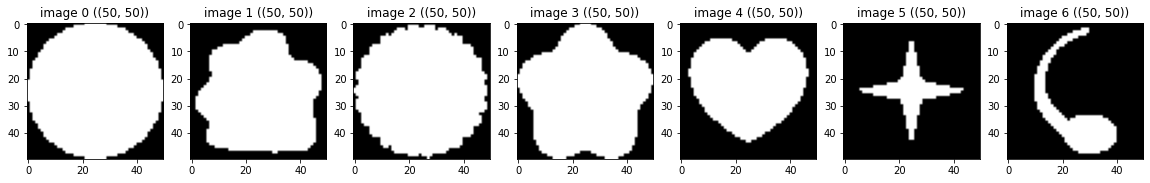

In [44]:

imgs_name = [
  "imgs/shapes/blob00.jpeg",
  "imgs/shapes/blob01.jpeg",
  "imgs/shapes/blob02.jpeg",
  "imgs/shapes/blob03.jpeg",
  "imgs/shapes/blob04.jpeg",
  "imgs/shapes/blob05.jpeg",
  "imgs/shapes/blob06.jpeg",
]

imgs = []

for name in imgs_name:

  # Read image
  # img = cv.imread("imgs/shapes/blob00.jpeg")
  # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  # Read image
  img = io.imread(name)
  img = np.mean(img, axis=2)

  # Resize, threshold and invert
  img = transform.resize(img, (50, 50))
  img = (img<100).astype(np.uint8) # To uint8 for openCV

  imgs.append(img)

fig, axis = plt.subplots(1, len(imgs), figsize=(20,20))

for i, img in enumerate(imgs):
  axis[i].set_title(f"image {i} ({img.shape})")
  axis[i].imshow(img, cmap='gray')


# Global descriptors

* $A \subset \mathbb{R^2}$ a shape
* $\Phi : \mathcal{P}( \mathbb{R^2} ) \to \mathbb{R^p} $ a descriptor that is not changed by some geometric transformations $T$ :
$$\Phi(T.A) = \Phi(A)$$
* The considered transformations are :
  * **Translation** by $t$ : $ \quad T(x) = x + t $
  * **Rotation** of angle $\theta$ ($M_\theta$ the rotation matrix) : $ \quad T(x) = M_\theta . x $
  * **Zoom** of magnitude $s \in \mathbb{R} $ : $ \quad T(x) = s . x $
  * **Affine transformations** $p$ a vector and $M$ an invertible matrix : $ \quad T(x) = M.x + p $


### Basic global descriptors

* **Circumference** $ \quad P(A)$
* **Surface** $ \quad S(A)$
* **Isometric ratio** or **Compactness** with the maximum value 1 for the circle : $ \quad R = \frac{4\pi S(A)}{P(A)^2} $
* **Diameter** $ \quad D(A) = max\{d(x,y) \quad ; \quad x,y \in A\} $
* **Bounding box** with fixed axis or adaptative axis
* **Elongation** : $ \quad E(A) = \frac{width_{bounding-box}}{length_{bounding-box}} $
* **Convex perimeter** is the perimeter of the convex hull of the shape
* **Convexity** $ \quad \frac{Convex-perimeter}{Perimeter} $
* **Symetry** $ \quad Sim(A) = \frac{S(A)}{S(A \cup A')} \quad $ with $ \quad A'=\{ -x : x \in A \} $ 
* Major/Minor axis
  * The **Major axis** is the longest segment between to boundary points of the shape.
  * The **Minor axis** is the segment *perpendicular* to the major axis between two boundary points of the shape.


............
............
............
............
............
............
............


<BarContainer object of 7 artists>

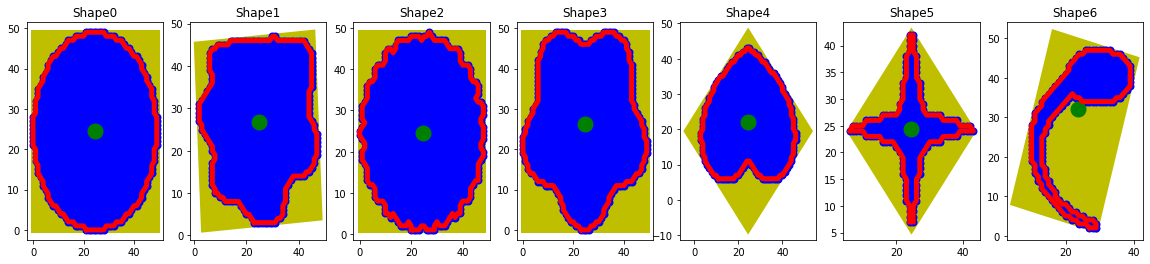

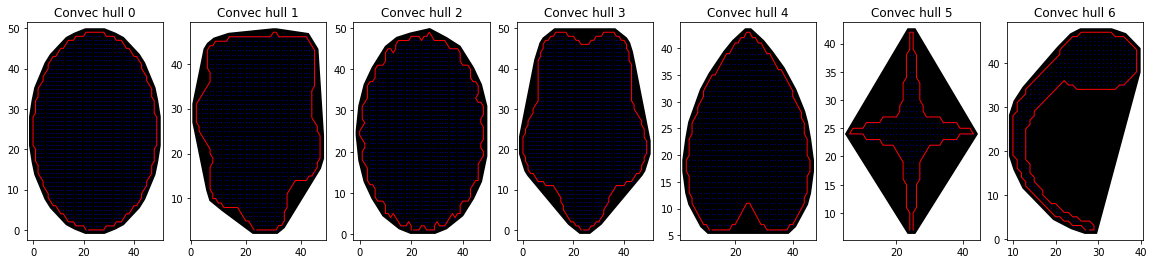

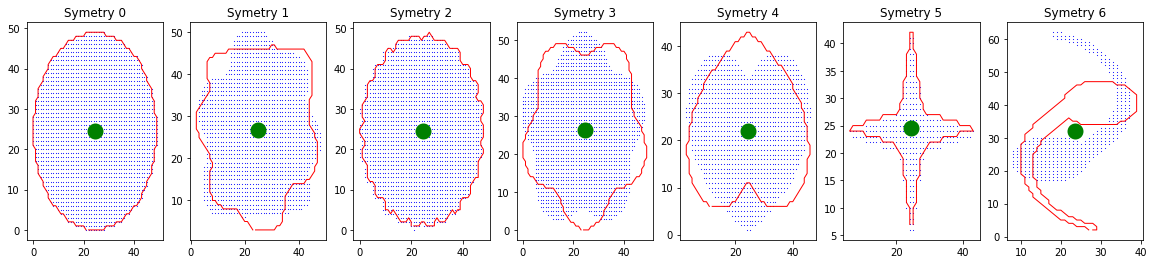

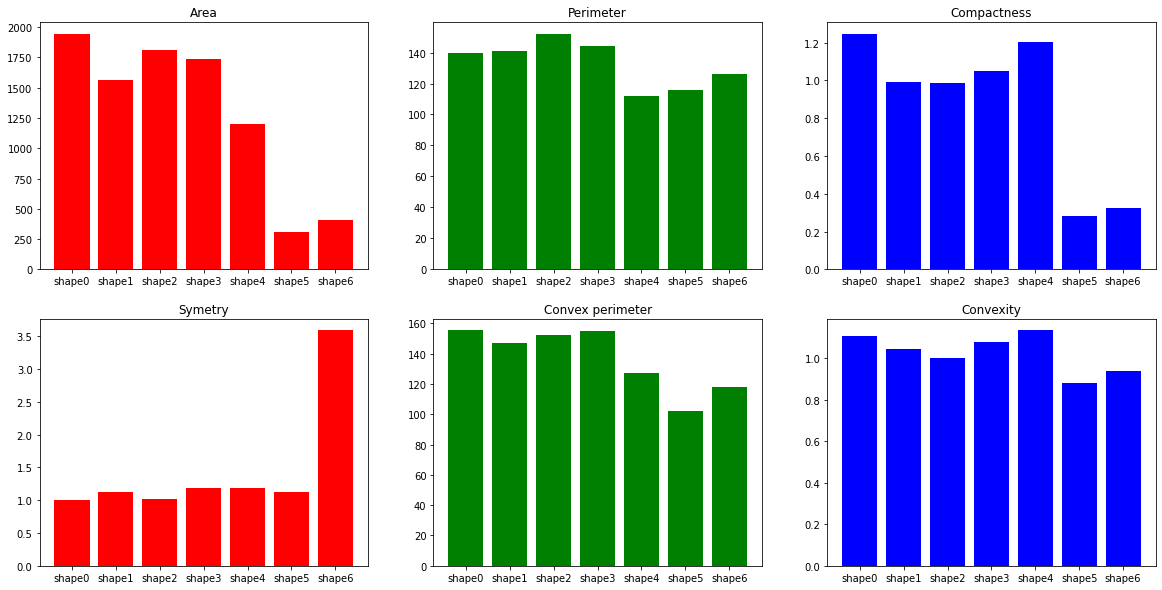

In [45]:

# Extract the shape points
def extract_shape_points(img):
  shape_points = []
  for l in range(img.shape[0]):
    for c in range(img.shape[1]):
      if img[l,c] == 1:
        shape_points.append([l,c])
  return np.array(shape_points)

def get_point_symetry(center, p):
  v = np.array([center[0]-p[0], center[1]-p[1]])
  return center + v

def get_shape_symetry(center, shape_points):
  sym = np.copy(shape_points)
  for i in range(sym.shape[0]):
    sym[i] = get_point_symetry(center, sym[i])
  return sym

def point_list_contains_point(plist, p):
  for l in plist:
    if l[0]==p[0] and l[1]==p[1]:
      return True
  return False

def points_lists_union(points1, points2):
  union = []
  for p in points1:
    if not point_list_contains_point(union, p):
      union.append(p)
  for p in points2:
    if not point_list_contains_point(union, p):
      union.append(p)
  return np.array(union)

def points_lists_union_(points1, points2):
  im1 = np.zeros((np.max(points1[:,0])+1, np.max(points1[:,1])+1))
  im2 = np.zeros((np.max(points2[:,0])+1, np.max(points2[:,1])+1))
  im = np.zeros((max(im1.shape[0], im2.shape[0]), max(im1.shape[1], im2.shape[1])))
  for p in points1:
    im1[p[0],p[1]] = 1
  for p in points2:
    im2[p[0],p[1]] = 1
  im[0:im1.shape[0], 0:im1.shape[1]] += im1
  im[0:im2.shape[0], 0:im2.shape[1]] += im2
  im = (im==2)*1
  return extract_shape_points(im)

def points_list_intersection(points1, points2):
  intersection = []
  for p in points1:
    if point_list_contains_point(points2, p):
      intersection.append(p)
  return intersection

shapes_points = []
shapes_boundary = []
shapes_center = []
shapes_bounding_box = []
shapes_convex_hull = []
shapes_symetry_points = []

convex_perimeters = []
convexities = []
areas = []
perimeters = []
compactnesses = []
symetries = []

for i, img in enumerate(imgs):
  
  # Shape points
  shape_points = extract_shape_points(img)
  shapes_points.append(shape_points)
  print(".", end="")

  # Shape boundary
  shape_boundary = cv.findContours(img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
  shape_boundary = shape_boundary[0][0]
  shape_boundary = np.squeeze(shape_boundary, axis=1)
  shape_boundary_ = np.copy(shape_boundary)
  shape_boundary[:,0] = shape_boundary_[:,1]
  shape_boundary[:,1] = shape_boundary_[:,0]
  shapes_boundary.append(shape_boundary)
  print(".", end="")

  # Bounding box
  bounding_box = cv.boxPoints(cv.minAreaRect(shape_points))
  shapes_bounding_box.append(bounding_box)
  print(".", end="")

  # Convex hull
  convex_hull = cv.convexHull(shape_points)
  convex_hull = np.squeeze(convex_hull, axis=1)
  shapes_convex_hull.append(convex_hull)
  print(".", end="")

  # Center of mass
  center = np.mean(shape_points, axis=0)
  shapes_center.append(center)
  print(".", end="")

  # Perimeters
  perimeter = shape_boundary.shape[0]
  perimeters.append(perimeter)
  print(".", end="")

  # Area
  area = shape_points.shape[0]
  areas.append(area)
  print(".", end="")

  # Compactness
  compactness = 4*math.pi*area/(perimeter**2)
  compactnesses.append(compactness)
  print(".", end="")

  # Convex perimeter
  convex_perimeter = cv.arcLength(convex_hull, True)
  convex_perimeters.append(convex_perimeter)
  print(".", end="")

  # Convexity
  convexity = convex_perimeter/perimeter
  convexities.append(convexity)
  print(".", end="")

  # Symetry points
  shape_symetry_points = get_shape_symetry(center, shape_points)
  shapes_symetry_points.append(shape_symetry_points)
  print(".", end="")

  # Symetry
  # shape_to_symetry_intersection = points_list_intersection(shape_symetry_points, shape_points)
  # shape_to_symetry_union_area = area+shape_symetry_points.shape[0]-shape_to_symetry_intersection.shape[0]
  shape_to_symetry_union = points_lists_union_(shape_symetry_points, shape_points)
  shape_to_symetry_union_area = shape_to_symetry_union.shape[0]
  symetry = area/shape_to_symetry_union_area
  symetries.append(symetry)

  print(".")

fig, axis = plt.subplots(1, len(imgs), figsize=(20,4))
for i in range(len(imgs)):
  axis[i].set_title(f"Shape{i}")
  axis[i].fill(shapes_bounding_box[i][:,1], shapes_bounding_box[i][:,0], color='y', linewidth=5)
  axis[i].scatter(shapes_points[i][:,1], shapes_points[i][:,0], color='b', marker="o", linewidth=2)
  axis[i].plot(shapes_boundary[i][:,1], shapes_boundary[i][:,0], color='r', linewidth=5)
  axis[i].scatter([shapes_center[i][1]], [shapes_center[i][0]], color='g', linewidth=10)

fig, axis = plt.subplots(1, len(imgs), figsize=(20,4))
for i in range(len(imgs)):
  axis[i].set_title(f"Convec hull {i}")
  axis[i].fill(shapes_convex_hull[i][:,1], shapes_convex_hull[i][:,0], color='black', linewidth=8)
  axis[i].scatter(shapes_points[i][:,1], shapes_points[i][:,0], color='b', linewidth=0.1, s=0.5, marker="o")
  axis[i].plot(shapes_boundary[i][:,1], shapes_boundary[i][:,0], color='r', linewidth=1)

fig, axis = plt.subplots(1, len(imgs), figsize=(20,4))
for i in range(len(imgs)):
  axis[i].set_title(f"Symetry {i}")
  axis[i].scatter(shapes_symetry_points[i][:,1], shapes_symetry_points[i][:,0], color='b', linewidth=0.1, s=1, marker="o")
  axis[i].plot(shapes_boundary[i][:,1], shapes_boundary[i][:,0], color='r', linewidth=1)
  axis[i].scatter([shapes_center[i][1]], [shapes_center[i][0]], color='g', linewidth=10)

fig, axis = plt.subplots(2, 3, figsize=(20, 10))
img_labels = [f"shape{i}" for i in range(len(imgs))]
axis[0, 0].set_title("Area")
axis[0, 0].bar(img_labels, areas, color='r')

axis[0, 1].set_title("Perimeter")
axis[0, 1].bar(img_labels, perimeters, color='g')

axis[0, 2].set_title("Compactness")
axis[0, 2].bar(img_labels, compactnesses, color='b')

axis[1, 0].set_title("Symetry")
axis[1, 0].bar(img_labels, symetries, color='r')

axis[1, 1].set_title("Convex perimeter")
axis[1, 1].bar(img_labels, convex_perimeters, color='g')

axis[1, 2].set_title("Convexity")
axis[1, 2].bar(img_labels, convexities, color='b')


### Moments

##### 1) <u> $(p,q)$-th moment </u>

**NB:** It's invariant to **translation**.

Let $p,q \in \mathbb{N}$. For a shape $A$ of mass center the pixel $(x_c,y_c)$ the **$(p,q)$-th moment** is defined as :

$$\boxed {
  m_{p,q} = \int_A (x-x_c)^p (y-y_c)^q dxdy
}$$


##### 2) <u> The normalized moment </u>

**NB:** It's invariant to **translation** and **zoom**.

$$\boxed {
  n_{p,q} = \frac{m_{p,q}}{m_{0,0}^{\alpha}}
  \quad with \quad \alpha = \frac{1}{2} (p+q) + 1
}$$

##### 3) <u> Invariant moments </u>

**NB:** Invariant to **translation**, **zoom** and **rotations**.

$$\begin{align*}
& \boxed{
  \phi_1 = n_{2,0} + n_{0,2}
} \\

& \boxed{
  \phi_2 = (n_{2,0} - n_{0,2})^2 + 4 n_{1,1}^2
} \\

& \boxed{
  \phi_3 = (n_{3,0} - 3 n_{1,2})^2 + (3 n_{2,1} - n_{0,3})^2
} \\

& \boxed{
  \phi_4 = (n_{3,0} + n_{1,2})^2 + (n_{2,1} + n_{0,3})^2
}
\end{align*}$$

##### 4) <u> Inertia matrix </u>

$$\boxed{
  \Sigma = 
  \begin{bmatrix}
    m_{2,0} & m_{1,1} \\
    m_{1,1} & m_{0,2}
  \end{bmatrix}
}$$

Let $\alpha_1$ > $\alpha_2$ be the eigen values of $\Sigma$.

**The elongation** is : $ \boxed{ e = \frac{\alpha_2}{\alpha_1} } \quad $ is invariant to rotations.

**The compacity** is : $ \boxed{ k = \frac{1}{4 \pi \sqrt{\alpha_1 \alpha_2}} } \quad $ is invariant to affine transformations.


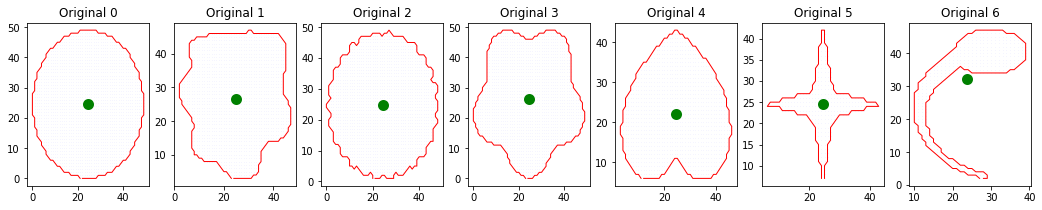

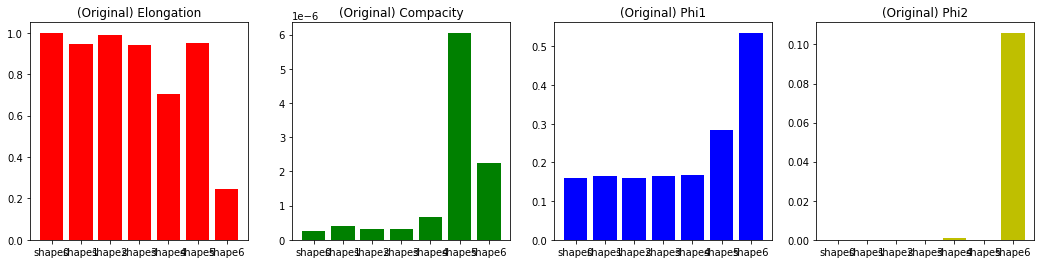

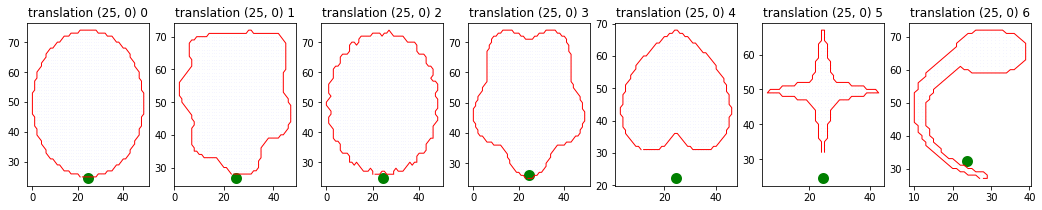

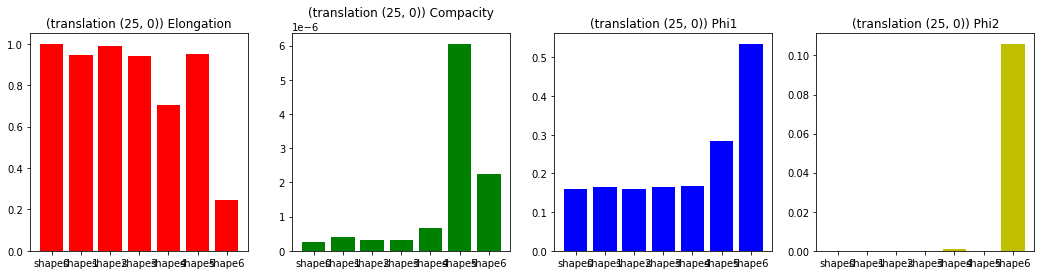

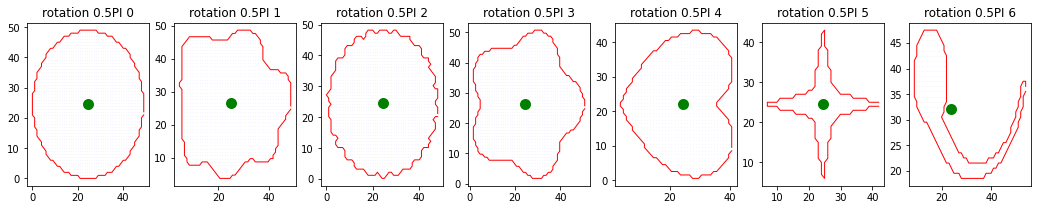

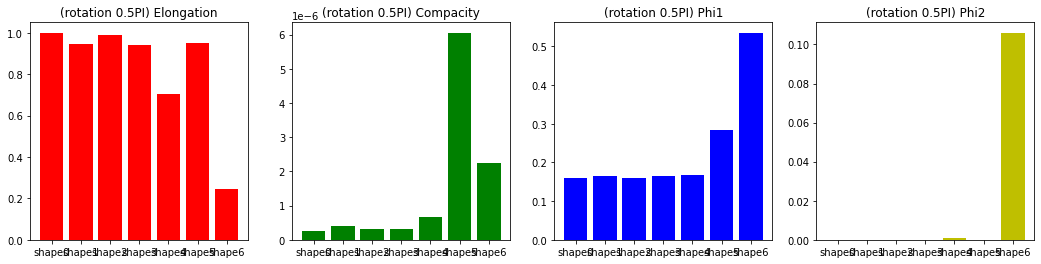

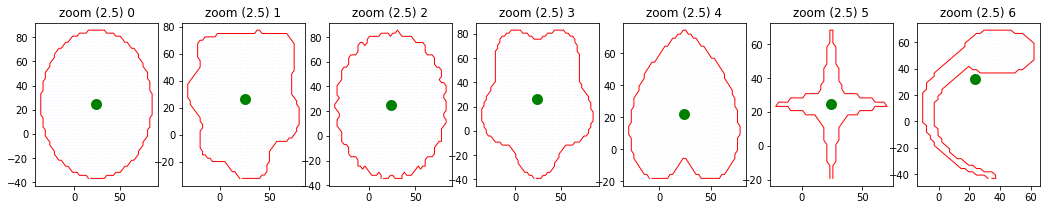

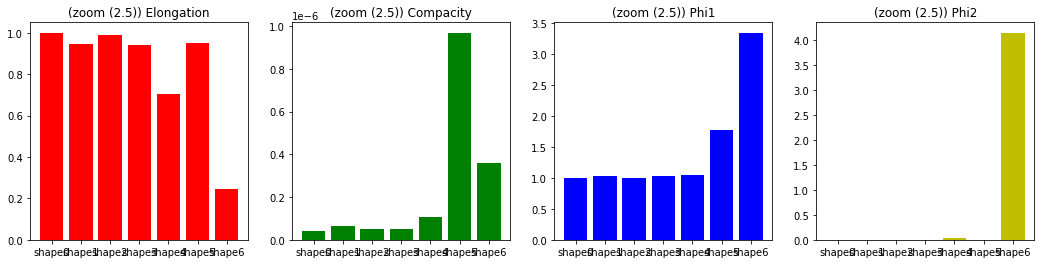

In [46]:

shapes_inertia_matrix = []
shapes_elongation = []
shapes_compacity = []
shapes_phi1 = []
shapes_phi2 = []

def compute_moment(points, boundary, p, q):
  x_ = np.mean(points[:,0])
  y_ = np.mean(points[:,1])
  return np.sum( ((points[:,0]-x_)**p) * ((points[:,1]-y_)**q) )

def updateDescriptors(shapes_points, shapes_boundary):
  global shapes_inertia_matrix
  global shapes_elongation
  global shapes_compacity
  global shapes_phi1
  global shapes_phi2
  for i in range(len(shapes_points)):
    # moments = cv.moments(shapes_boundary[i])
    # mu20 = moments['mu20']
    # mu11 = moments['mu11']
    # mu02 = moments['mu02']
    # nu20 = moments['nu20']
    # nu02 = moments['nu02']
    # nu11 = moments['nu11']

    mu20 = compute_moment(shapes_points[i], shapes_boundary[i], 2, 0)
    mu11 = compute_moment(shapes_points[i], shapes_boundary[i], 1, 1)
    mu02 = compute_moment(shapes_points[i], shapes_boundary[i], 0, 2)
    mu00 = compute_moment(shapes_points[i], shapes_boundary[i], 0, 0)

    nu20 = compute_moment(
      shapes_points[i], shapes_boundary[i], 2, 0
      ) / (mu00**2)
    nu02 = compute_moment(
      shapes_points[i], shapes_boundary[i], 0, 2
      ) / (mu00**2)
    nu11 = compute_moment(
      shapes_points[i], shapes_boundary[i], 1, 1
      ) / (mu00**2)

    inertia_matrix = np.array([
      [mu20, mu11],
      [mu11, mu02]
    ])
    shapes_inertia_matrix.append(inertia_matrix)

    eigenval, eigenvec = np.linalg.eig(inertia_matrix)
    alpha1 = eigenval[1]
    alpha2 = eigenval[0]
    if eigenval[0]>eigenval[1]:
      alpha1 = eigenval[0]
      alpha2 = eigenval[1]

    elongation = alpha2/alpha1
    compacity = 1.0/(4*math.pi*math.sqrt(alpha2*alpha1))
    shapes_elongation.append(elongation)
    shapes_compacity.append(compacity)

    phi1 = nu20 + nu02
    phi2 = (nu20 - nu02)**2 + 4*nu11**2
    shapes_phi1.append(phi1)
    shapes_phi2.append(phi2)

def clear_descriptors():
  global shapes_inertia_matrix
  global shapes_elongation
  global shapes_compacity
  global shapes_phi1
  global shapes_phi2
  shapes_inertia_matrix = []
  shapes_elongation = []
  shapes_compacity = []
  shapes_phi1 = []
  shapes_phi2 = []

def applyRotationToPoints(center, angleRad, points):
  rotMat = np.array([
    [math.cos(angleRad), math.sin(angleRad)],
    [-math.sin(angleRad), math.cos(angleRad)]
  ])
  res = np.zeros(points.shape)
  for i in range(points.shape[0]):
    res[i] = np.matmul(rotMat, (points[i]-center))
    res[i] = res[i] + center
  return res

def applyScalingToPoints(center, scale, points):
  scaleMat = np.array([
    [scale, 0],
    [0, scale]
  ])
  res = np.zeros(points.shape)
  for i in range(points.shape[0]):
    res[i] = np.matmul(scaleMat, (points[i]-center))
    res[i] = res[i] + center
  return res

def applyTranslationToPoints(vect, points):
  res = np.zeros(points.shape)
  for i in range(points.shape[0]):
    res[i] = points[i] + vect
  return res

def displayResults(shapes_points, shapes_boundary, title):
  fig, axis = plt.subplots(1, len(shapes_boundary), figsize=(18,3))
  for i in range(len(imgs)):
    axis[i].set_title(f"{title} {i}")
    axis[i].plot(shapes_boundary[i][:,1], shapes_boundary[i][:,0], color='r', linewidth=1)
    axis[i].scatter(shapes_points[i][:,1], shapes_points[i][:,0], color='b', linewidth=0.1, s=0.01, marker="o")
    axis[i].scatter([shapes_center[i][1]], [shapes_center[i][0]], color='g', linewidth=5)

  fig, axis = plt.subplots(1, 4, figsize=(18, 4))
  img_labels = [f"shape{i}" for i in range(len(shapes_boundary))]
  axis[0].set_title(f"({title}) Elongation")
  axis[0].bar(img_labels, shapes_elongation, color='r')

  axis[1].set_title(f"({title}) Compacity")
  axis[1].bar(img_labels, shapes_compacity, color='g')

  axis[2].set_title(f"({title}) Phi1")
  axis[2].bar(img_labels, shapes_phi1, color='b')

  axis[3].set_title(f"({title}) Phi2")
  axis[3].bar(img_labels, shapes_phi2, color='y')

# Update descriptors
updateDescriptors(shapes_points, shapes_boundary)
displayResults(shapes_points, shapes_boundary, "Original")

clear_descriptors()
# Translate
trans_shapes_boundary = []
trans_shapes_points = []
vect = np.array([25, 0])
for i in range(len(shapes_boundary)):
  trans_boundary = applyTranslationToPoints(vect, shapes_boundary[i])
  trans_shapes_boundary.append(trans_boundary)
  trans_points = applyTranslationToPoints(vect, shapes_points[i])
  trans_shapes_points.append(trans_points)
# Update descriptors
updateDescriptors(trans_shapes_points, trans_shapes_boundary)
displayResults(trans_shapes_points, trans_shapes_boundary, f"translation {vect[0], vect[1]}")

clear_descriptors()
# Rotate
rot_shapes_boundary = []
rot_shapes_points = []
angle = math.pi/2
for i in range(len(shapes_boundary)):
  rot_boundary = applyRotationToPoints(shapes_center[i], angle, shapes_boundary[i])
  rot_shapes_boundary.append(rot_boundary)
  rot_points = applyRotationToPoints(shapes_center[i], angle, shapes_points[i])
  rot_shapes_points.append(rot_points)
# Update descriptors
updateDescriptors(rot_shapes_points, rot_shapes_boundary)
displayResults(rot_shapes_points, rot_shapes_boundary, f"rotation {(angle/math.pi)}PI")

clear_descriptors()
# Zoom
zoom_shapes_boundary = []
zoom_shapes_points = []
zoom = 2.5
for i in range(len(shapes_boundary)):
  zoom_boundary = applyScalingToPoints(shapes_center[i], zoom, shapes_boundary[i])
  zoom_shapes_boundary.append(zoom_boundary)
  zoom_points = applyScalingToPoints(shapes_center[i], zoom, shapes_points[i])
  zoom_shapes_points.append(zoom_points)
# Update descriptors
updateDescriptors(zoom_shapes_points, zoom_shapes_boundary)
displayResults(zoom_shapes_points, zoom_shapes_boundary, f"zoom ({zoom})")



### Fourier descriptors

The shape is represented by its boundary points $ \quad {Z_0, ..., Z_{N-1}} \quad $ and each $ \quad Z_k = x_k + iy_k \quad $.

The Discrete Fourier transform of the shape is :

$$\boxed{
  \begin{align*}
    & \hat{Z_k} = \frac{1}{N} \sum_{i=0}^{N-1} Z_i e^{\frac{-2i\pi kv}{N}} \\
    & for \quad k \in \{ -\frac{N}{2}+1, ... , \frac{N}{2} \}
  \end{align*}
}$$

The descriptor is (or a subset of) : $\quad ( \hat{Z_k}_{-\frac{N}{2}+1}, ... , \hat{Z_k}_{\frac{N}{2}})$


* $\hat{Z_0} \quad $ is the barycenter of the shape.
* for $ \quad k \neq 0 $, $ \quad \hat{Z_k} \quad $ is invariant by translation.
* $ \quad |\hat{Z_k}| \quad$ is invariant by rotation.
* $ \quad \hat{Z_k} / |\hat{Z_1}| \quad$ is invariant by zoom.


[ 3.74317114e+00-1.90724096e+00j -9.44220528e-15-1.66406030e-14j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -7.73900742e-01-1.22573836e-01j -1.66406030e-14-9.44220528e-15j]
[-3.85058611-0.39037722j -2.52572256+2.34189275j -0.43077997+0.40466289j
 -0.24173612-1.68015486j  1.54870539+2.34019356j  3.11963128+2.06723063j]
[-6.87934114+1.82499465j -4.1754666 -0.12925496j -3.00019961+1.51755479j
 -1.        +4.j          1.65277235-4.11421383j  2.1615176 +2.93387071j]
[ 1.82137337+1.01196191e-01j -2.57600738+2.61187924e+00j
  6.07857043-8.16752702e-01j  4.        +8.88178420e-16j
 -0.43376546+3.89911657e-01j -3.15066215-2.68753397e+00j]
[-1.16600078-2.15024844j  1.30683602-3.7878019j  -1.64949703-0.76274528j
 -3.        +1.j         -1.51100982-1.3054572j   0.68114631+2.52092478j]
[-3.66707218+0.29859993j  1.72161918-0.09334348j  2.05051827-0.05554714j
 -2.        +0.j         -1.46574136-0.03970593j  0.17010301+0.00922272j]
[-0.50221064-2.49086333e+00j  1.65302654-3.9

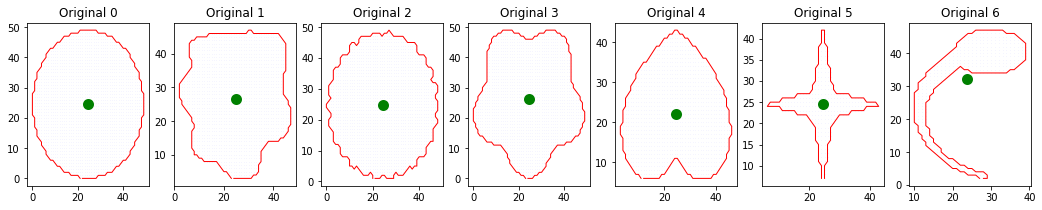

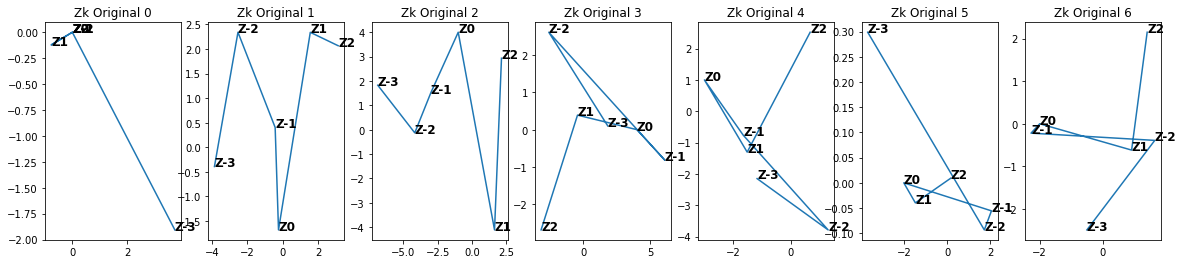

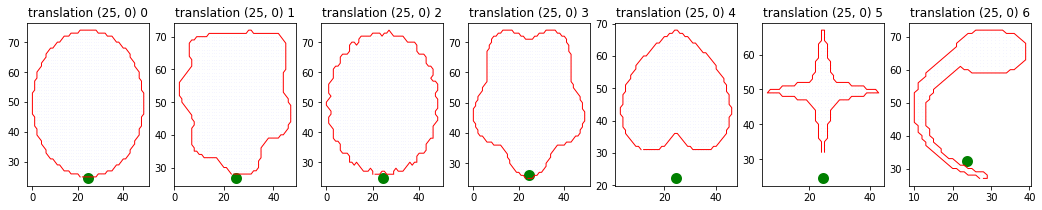

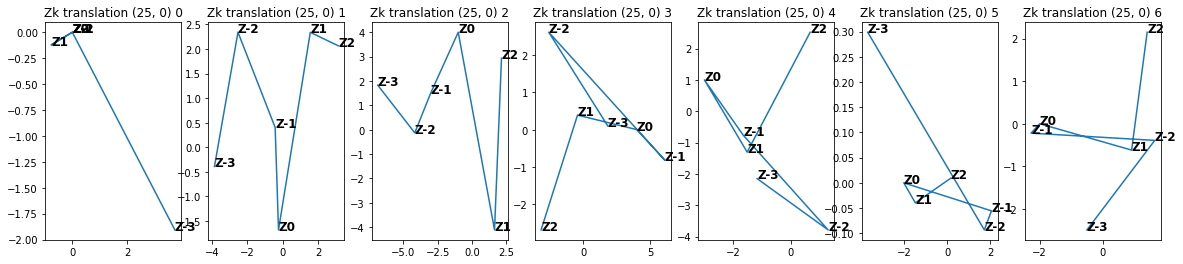

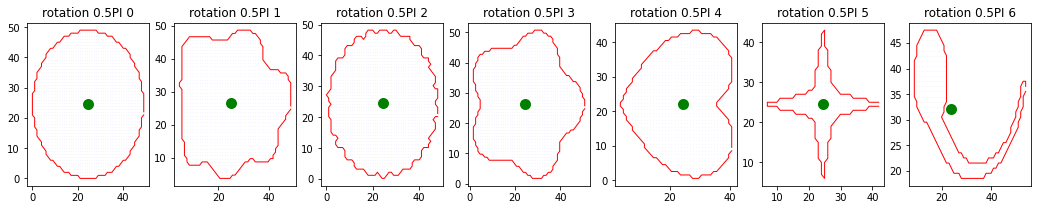

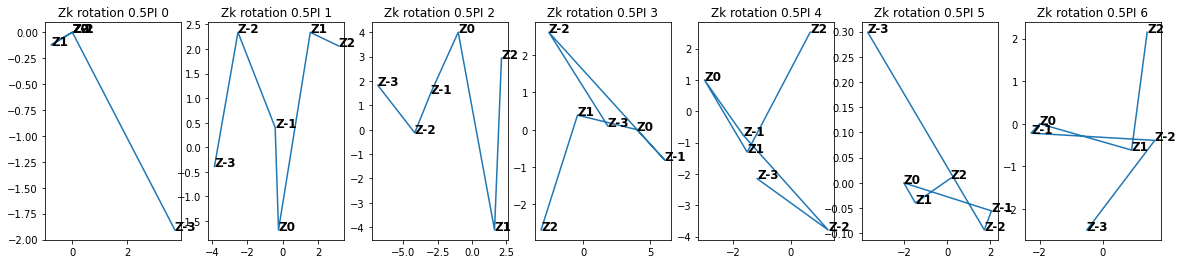

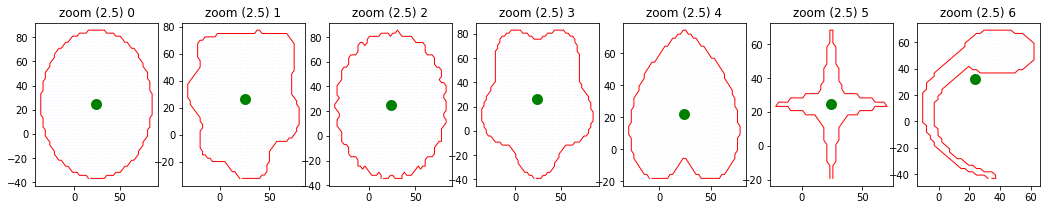

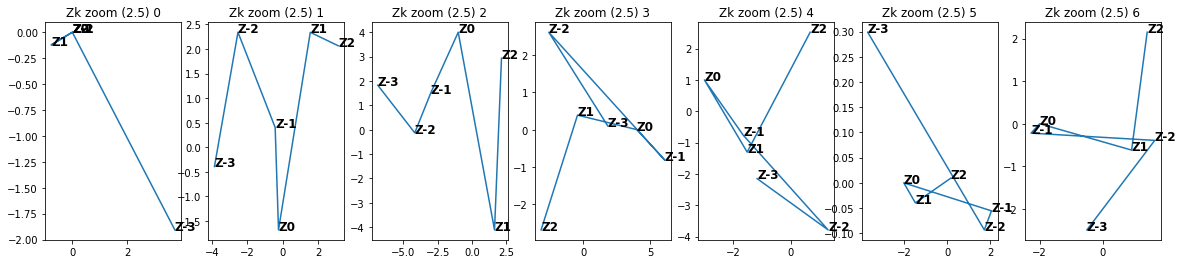

In [48]:

shapes_fft = []

def updateDescriptors(shapes_points, shapes_boundary):
  for i in range(len(shapes_boundary)):
    complex_boundary = np.array([ p[1] + p[0]*1j for p in shapes_boundary[i] ])
    fft = np.fft.fft(complex_boundary)
    shapes_fft.append(fft)

def displayResults(shapes_points, shapes_boundary, title):
  fig, axis = plt.subplots(1, len(shapes_boundary), figsize=(18,3))
  for i in range(len(imgs)):
    axis[i].set_title(f"{title} {i}")
    axis[i].plot(shapes_boundary[i][:,1], shapes_boundary[i][:,0], color='r', linewidth=1)
    axis[i].scatter(shapes_points[i][:,1], shapes_points[i][:,0], color='b', linewidth=0.1, s=0.01, marker="o")
    axis[i].scatter([shapes_center[i][1]], [shapes_center[i][0]], color='g', linewidth=5)

  fig, axis = plt.subplots(1, len(shapes_boundary), figsize=(20,4))
  for i in range(len(imgs)):
    N = len(shapes_boundary[i])
    zero = int(N/2)
    n = min(N, 3)
    indices_around_zero = [i+zero for i in range(-n, n, 1)]
    indices_around_zero_i = [i for i in range(-n, n, 1)]
    indices_around_zero_i_n = [f"Z{i}" for i in range(-n, n, 1)]

    print(shapes_fft[i][indices_around_zero])

    axis[i].set_title(f"Zk {title} {i}")
    axis[i].plot(
      np.real(shapes_fft[i])[indices_around_zero],
      np.imag(shapes_fft[i])[indices_around_zero],)
    for l, z in enumerate(indices_around_zero_i_n):
      axis[i].text(
        np.real(shapes_fft[i][indices_around_zero[l]]),
        np.imag(shapes_fft[i][indices_around_zero[l]]),
        z, fontweight='bold', fontsize='large')

# Update descriptors
updateDescriptors(shapes_points, shapes_boundary)
displayResults(shapes_points, shapes_boundary, "Original")

print("Translation")
clear_descriptors()
updateDescriptors(trans_shapes_points, trans_shapes_boundary)
displayResults(trans_shapes_points, trans_shapes_boundary, f"translation {vect[0], vect[1]}")

print("Rotation")
clear_descriptors()
updateDescriptors(rot_shapes_points, rot_shapes_boundary)
displayResults(rot_shapes_points, rot_shapes_boundary, f"rotation {(angle/math.pi)}PI")

print("Zoom")
clear_descriptors()
updateDescriptors(zoom_shapes_points, zoom_shapes_boundary)
displayResults(zoom_shapes_points, zoom_shapes_boundary, f"zoom ({zoom})")


